# Introduction
This notebook is ment as an interactive sub-part of the implementation used for achiving the results as descirbed in the paper. Here the notebook will show the implementation and adobtation on the MOONS dataset generated from the sklearn python library. 

Where this implementation varies from the full implementation will be noted on top of every section 

In [81]:
import numpy as np
import torch
from datetime import datetime
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_moons
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import sklearn.datasets
import math
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import sklearn
from sklearn import metrics
import pickle as pkl

This is a helper function which is used to run the implementation on GPU if it is available

In [82]:
def get_variable(x, **kwargs):
    if torch.cuda.is_available():
        return Variable(x, **kwargs).cuda()
    else:
        return Variable(x, **kwargs)


### Model
The model is the class that trains on the specific domain. It takes in the architectur as given from the controller, and returns a test-accuracy, which is then used to update the REINFORCE policy

In [83]:
def mse_loss(ys, ts):
    return torch.mean((ys-ts)**2)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    ys = torch.argmax(ys,dim=-1)
    ts = torch.argmax(ts,dim=-1)
    return torch.mean(torch.eq(ys,ts).type(torch.FloatTensor)).cpu().data.numpy()

def cross_entropy(ys, ts):
    # computing cross entropy per sample
    cross_entropy = -torch.sum(ts * torch.log(ys), dim=1, keepdim=False)
    # averaging over samples
    return torch.mean(cross_entropy)

# Network
class Net_MOONS(nn.Module):

    # Constructor to build network
    def __init__(self, string, in_features, num_classes, layers):

        # Inherit from parent constructor
        super(Net_MOONS, self).__init__()

        num_input = in_features

        # Break down string sent from Controller
        # and add layers in network based on this
        for s in string:

            # If element in string is not a number (i.e. an activation function)
            if s is 'ReLU':
                layers.append(nn.ReLU())
            elif s is 'Tanh':
                layers.append(nn.Tanh())
            elif s is 'Sigmoid':
                layers.append(nn.Sigmoid())
            # If element in string is a number (i.e. number of neurons)
            else:
                s_int = int(s)
                layers.append(nn.Linear(num_input, s_int))
                num_input = s_int

        # Last layer with output 2 representing the two classes
        layers.append(nn.Linear(num_input, num_classes))
        layers.append(nn.Softmax(dim=-1))

class Train_model():

    def __init__(self, params):
        self.X_train = 0
        self.y_train = 0
        self.X_val = 0
        self.y_val = 0
        self.X_test = 0
        self.y_test = 0
        self.params = params
        self.train_loader = 0
        self.test_loader = 0

    def moon_data(self, num_samples, noise_val):
        # num_samples should be divisable by 5

        # Import dataset
        X, y = make_moons(n_samples=num_samples, noise=noise_val)

        # Define interval used to split data into
        # train, val and test
        interval_1 = int((num_samples/5)*3)
        interval_2 = int((num_samples/5)*4)

        # Define train, validation, and test sets
        self.X_train = X[:interval_1].astype('float32')
        self.X_val = X[interval_1:interval_2].astype('float32')
        self.X_test = X[interval_2:].astype('float32')

        # and labels
        self.y_train = y[:interval_1].astype('int32')
        self.y_val = y[interval_1:interval_2].astype('int32')
        self.y_test = y[interval_2:].astype('int32')

        self.X_train = get_variable(torch.from_numpy(self.X_train))
        self.y_train = get_variable(torch.from_numpy(onehot(self.y_train,2)).float())

        self.X_val = get_variable(torch.from_numpy(self.X_val))
        self.y_val = get_variable(torch.from_numpy(onehot(self.y_val,2)).float())

        self.X_test = get_variable(torch.from_numpy(self.X_test))
        self.y_test = get_variable(torch.from_numpy(onehot(self.y_test,2)).float())
        
    
    # A plotter to validate correct implementation of the model
    def plotter(self, accuracies, losses, val_accuracies, val_losses):

        plot_train_losses, plot_val_losses, plot_train_accuracies, plot_val_accuracies = [], [], [], []

        divider = 10
        divide_data = False

        if divide_data:
            for i in range(int(len(val_losses) / divider)):
                plot_val_losses.append(val_losses[i*divider])
                plot_val_accuracies.append(val_accuracies[i*divider])
            for i in range(int(len(losses) / divider)):
                plot_train_losses.append(losses[i*divider])
                plot_train_accuracies.append(accuracies[i*divider])

            val_epochs = int(len(val_losses) / divider)
            train_epochs = int(len(losses) / divider)

        else:

            plot_train_losses = losses
            plot_train_accuracies = accuracies
            plot_val_losses = val_losses
            plot_val_accuracies = val_accuracies

            val_epochs = len(val_losses)
            train_epochs = len(losses)

        plt.figure()
        plt.plot(range(train_epochs), plot_train_losses, 'r', label='Train Loss')
        plt.plot(range(val_epochs), plot_val_losses, 'b', label='Test Loss')
        plt.legend()
        plt.xlabel('Updates')
        plt.ylabel('Loss')

        plt.figure()
        plt.plot(range(train_epochs), plot_train_accuracies, 'r', label='Train Acc')
        plt.plot(range(val_epochs), plot_val_accuracies, 'b', label='Test Acc')
        plt.legend()
        plt.xlabel('Updates')
        plt.ylabel('Accuracy')
        plt.show()
    
    
    def train(self,net,train_batch_size,val_batch_size, plot):

        optimizer = optim.Adam(net.parameters(), lr=self.params["lr"])

        accuracies, losses, val_accuracies, val_losses, r2_scores, val_r2_scores = [], [], [], [], [], []

        train_loader = math.ceil(len(self.X_train)/train_batch_size)
        test_loader = math.ceil(len(self.X_val)/val_batch_size)

        # Variables used for EarlyStopping
        es_old_val, es_new_val, counter = 0, 0, 0
        es_range = 0.001
        es_limit = 30

        for e in range(self.params["num_epochs"]):

            # --------------- train the model --------------- #
            for batch in range(train_loader):

                optimizer.zero_grad()

                if batch == (train_loader - 1):
                    slce = slice(batch * train_batch_size, -1)
                else:
                    slce = slice(batch * train_batch_size, (batch + 1) * train_batch_size)

                preds = net(self.X_train[slce])
                loss = cross_entropy(preds, self.y_train[slce])

                loss.backward()
                optimizer.step()

                acc = accuracy(preds, self.y_train[slce])
                accuracies.append(acc)
                losses.append(loss.cpu().data.numpy())

            # --------------- test the model --------------- #
            for batch in range(test_loader):

                if batch == (test_loader - 1):
                    val_slce = slice(batch * val_batch_size, -1)
                else:
                    val_slce = slice(batch * val_batch_size, (batch + 1) * val_batch_size)

                val_preds = net(self.X_val[val_slce])

                val_loss = cross_entropy(val_preds, self.y_val[val_slce])
                val_acc = accuracy(val_preds, self.y_val[val_slce])

                val_losses.append(val_loss.cpu().data.numpy())
                val_accuracies.append(val_acc)

                # Early stopping
                if e == 0:
                    es_old_val = float(val_acc)
                else:
                    es_new_val = float(val_acc)

                    if abs(es_old_val - es_new_val) <= es_range:
                        counter += 1
                        if counter == es_limit:
                            break
                    else:
                        counter = 0
                        es_old_val = float(val_acc)
            
        if plot:
            self.plotter(accuracies, losses, val_accuracies, val_losses)

        # Returns the last valdation accuracy
        return val_acc

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=5, out_features=6, bias=True)
  (5): Tanh()
  (6): Linear(in_features=6, out_features=2, bias=True)
  (7): Softmax(dim=-1)
)


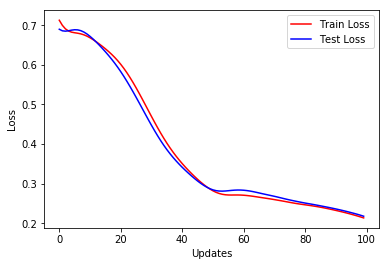

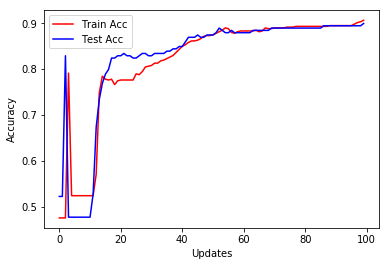

0.8994975


In [84]:
#testing the model
params = {
    "num_epochs": 100,
    "lr": 0.01
}

plot = True

train_m = Train_model(params)
layers = []
test_string = ('10', 'ReLU', '5', 'Sigmoid', '6', 'Tanh')
train_m.moon_data(1000, 0.2)
network = Net_MOONS(string=test_string, in_features=2, num_classes=2, layers=layers)
# Defining Network
net = nn.Sequential(*layers)
print(net)
train_batch_size = len(train_m.X_train)
val_batch_size = len(train_m.X_val)

val_accuracy = train_m.train(net, train_batch_size, val_batch_size, plot)
print(val_accuracy)

### Controller

The class below defines the controller which is the heart of AutoML. Here we do have implementation to handle MNIST and the Particle dataset as descibed in the paper, but the core of the controller is virtually the same. For testing purposis we also did have the ability to switch between using baseline or not as well as entropy or not. This implemetation only showcase where we use both moving baseline and entropy since this is the implementation which gives the overall best results, as stated in the paper. 

In [85]:
# Difine the action spaces for the nodes size and the activation which can be picked in between
# Notice here that the architecture always ends on an activation, if any
sizes_dict={
    0:"term",
    1:2,
    2:4,
    3:8,
    4:16,
    5:32,
    6:64,
}
activations_dict={
    0:"ReLU",
    1:"Tanh",
    2:"Sigmoid",
}

#hyper parameters 
num_blocks = 12 # the depths of the network
hidden_dim = 50 # the dimention of the memory transfered between each action
dictionaries = [activations_dict,sizes_dict] 

class Controller(nn.Module):
    def __init__(self,lr):
        self.reward = 0
        self.beta = 1
        super(Controller, self).__init__()
        # Create tokens which maps the amount of options for each layer
        # Recurrent layer

        self.rnncell = nn.GRUCell(
            input_size=hidden_dim,
            hidden_size=hidden_dim
            )

        #Linear layer for each of the block - decoder
        self.decoders=[]
        
        #Empty list to hold the actionspaces in order
        self.num_tokens = []
        
        for i in range(num_blocks):
            self.num_tokens += [len(sizes_dict), len(activations_dict)]
        for size in self.num_tokens:
            decoder = torch.nn.Linear(hidden_dim, size)
            self.decoders.append(decoder)

        self.optimizer = optim.Adam(self.parameters(), lr = lr)

    # You can see the forward pass as an action taken by the agent
    def forward(self, inputs, hidden, block_id):
        h = self.rnncell(inputs, hidden)
        logits = self.decoders[block_id](h)
        return logits.squeeze(), h

    def loss(self, log_prob, accuracy , baseline):
        R = torch.ones(1)*(accuracy+self.reward)
        adv = R - baseline
        entropy = torch.tensor(self.entropies)*self.beta
        loss = -(torch.mean(torch.sub(torch.mul(log_prob, get_variable(adv)),get_variable(entropy))))
        return loss

    # The sample here is then the whole episode where the agent takes x amounts of actions, at most num_blocks
    def sample(self):
        self.reward = 0
        self.entropies = []
        if self.beta > 0.1:
            self.beta*=0.999
        # tuple of h and c
        hidden = get_variable(torch.zeros(1,hidden_dim), requires_grad=False)
        input = get_variable(torch.zeros(1,hidden_dim), requires_grad=False)
        arch = []
        prob_list = []
        logProb_list = []
        indx = 0
        for block_id in range(0,num_blocks*2):
            #handle terminate argument
            #parse last hidden using overwrite
            logits, hidden = self.forward(input, hidden, block_id)
            # use logits to make choice

            probs = F.softmax(logits, dim=-1)
            log_prob = F.log_softmax(logits, dim=-1)
            entropy = -(log_prob * probs).sum(dim=-1)
            self.entropies.append(entropy)
            
            
            # draw from probs
            action = probs.multinomial(num_samples=1).data
            #append to return list which is used as the probs
            logProb_list.append(log_prob.gather(0,action))
            # determine whether activation or hidden
            if block_id%2==1:
                arch.append(activations_dict[int(action)])
            else:
                value = sizes_dict[int(action)]
                if value=="term":
                    break
                else:
                    arch.append(value)

        logProb_list = torch.cat(logProb_list,dim=-1)
        #return activations, nodes
        return arch, logProb_list

In [86]:
#Testing the controller
net = Controller(0.1)
if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    net.cuda()
for _ in range(0,5): 
    arch,l = net.sample()
    print("Network archtecture and the log-probability:")
    print(arch)
    print(l)
    print()


Network archtecture and the log-probability:
[64, 'Tanh']
tensor([-1.9833, -1.0922, -1.8175], grad_fn=<CatBackward>)

Network archtecture and the log-probability:
[16, 'Sigmoid', 2, 'Tanh']
tensor([-1.9824, -1.0809, -1.9432, -0.9908, -1.8008], grad_fn=<CatBackward>)

Network archtecture and the log-probability:
[2, 'ReLU', 8, 'Tanh', 4, 'Tanh', 8, 'Sigmoid', 8, 'Tanh']
tensor([-1.8543, -1.1233, -1.9574, -0.9908, -1.9824, -1.0486, -1.9942, -1.1421,
        -2.0398, -1.0985, -1.9033], grad_fn=<CatBackward>)

Network archtecture and the log-probability:
[16, 'Sigmoid', 8, 'Tanh', 4, 'ReLU', 16, 'Tanh', 2, 'ReLU']
tensor([-1.9824, -1.0809, -1.9574, -0.9908, -1.9824, -1.1628, -1.9511, -1.1484,
        -1.8141, -1.1764, -1.9033], grad_fn=<CatBackward>)

Network archtecture and the log-probability:
[64, 'Sigmoid', 32, 'Tanh']
tensor([-1.9833, -1.0809, -2.0408, -0.9908, -1.8008], grad_fn=<CatBackward>)



### Trainer
The only thing we need now is a trainer to create and controlle the contection between the model and the controller. Here we train the model on the same architecture five times to get an average accuracy for that architecture. 

The result over time is saved in a pickle file, such that the result can be viewed for each run, whenever you like. 


In [87]:
def trainer(epochs,lr):

    cont = Controller(lr)
    
    # Change HERE if conv = True
    if torch.cuda.is_available():
        print('##converting Controller to cuda-enabled')
        cont.cuda()
        for decoder in cont.decoders:
            decoder.cuda()
    accuracy_hist = []
    loss_hist = []
    sample_networks = []

    plot = False

    params = {
        "num_epochs": 500,
        "lr": 0.01
    }
    
    decay = 0.95
    baseline = 0.85
    train_m = Train_model(params)

    train_m.moon_data(num_samples=1000, noise_val=0.2)

    for e in range(epochs):
        
        arch,probs = cont.sample()

        # Defining Network
        layers = []
        network = Net_MOONS(string=arch, in_features=2, num_classes=2, layers=layers)
        net = nn.Sequential(*layers)

        if torch.cuda.is_available():
            net.cuda()
        
        
        accuracy,number_net_train = 0,5
        
        for _ in range(number_net_train):
            accuracy += train_m.train(net=net, train_batch_size=len(train_m.X_train), val_batch_size=len(train_m.X_val), plot=plot)
        
        accuracy /= number_net_train
        
        accuracy = torch.tensor(accuracy)
        accuracy_hist.append(accuracy)
        if e > (epochs-50):
            sample_networks.append(arch)

        cont.optimizer.zero_grad()

        # moving average baseline
        if decay > 1:
            decay = 1
        rewards = accuracy
        baseline = decay * baseline + (1 - decay) * rewards

        loss = cont.loss(probs,accuracy,baseline)
        
        loss_hist.append(float(loss.data))
        loss.backward()
        cont.optimizer.step()

    return accuracy_hist, loss_hist, sample_networks


def main():
    epochs = 1000
    lr = 0.01
    print("started traning the controller on MOONS with {} epochs".format(epochs))
    acc_his, loss_his, archs = trainer(epochs,lr)
    
    
    timestamp = datetime.now().strftime("%H%M%S-%d%m%Y")
    pklFile = "notebook_" + timestamp + '.pkl'
    with open(pklFile, 'wb') as handle:
        pkl.dump((acc_his, loss_his, archs), handle, protocol=pkl.HIGHEST_PROTOCOL)
    print("Traning in now done, and you can view the accuracy in the {} file".format(pklFile))
    
if __name__ == "__main__":
    main()


started traning the controller on MOONS with 1000 epochs
Traning in now done, and you can view the accuracy in the notebook_220408-25122019.pkl file


### plotter 
This is the plotter function which you can use to visualise your run

acc: 0.9397185516357421
[64, 'Sigmoid', 64, 'ReLU', 4, 'Tanh', 16, 'ReLU', 8, 'Sigmoid', 4, 'Tanh', 64, 'Tanh', 64, 'ReLU', 64, 'Tanh']
[32, 'Sigmoid']
[8, 'Sigmoid']
[16, 'Sigmoid']
[64, 'Sigmoid', 2, 'Sigmoid', 16, 'Sigmoid', 8, 'Sigmoid', 16, 'Tanh', 16, 'Tanh', 16, 'ReLU']
[16, 'Sigmoid']
[32, 'Sigmoid']
[]
[64, 'Sigmoid']
[8, 'Sigmoid']


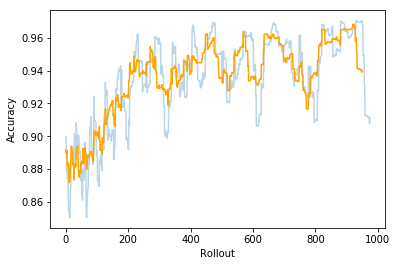

In [89]:
pklFile = "notebook_220408-25122019.pkl"
with open(pklFile, 'rb') as handle:
        accs, losses, archs = pkl.load(handle)

        
        
        
# Helps to plot the accuracy for better interpretation
N = 50
cumsum, moving_aves = [0], []
for i, x in enumerate(accs, 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
        #can do stuff with moving_ave here
        moving_aves.append(moving_ave)

#print the last accuracy average over the same as plottet
print("acc:", np.sum(accs[-N:])/len(accs[-N:]))

# This average over fewer data to showcase the variance in gradient policy methods (REINFORCE)
N = 25
cumsum, moving_aves_std = [0], []
for i, x in enumerate(accs, 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
        #can do stuff with moving_ave here
        moving_aves_std.append(moving_ave)
moving_aves = np.array(moving_aves)
moving_aves_std = np.array(moving_aves_std)

# Generate the figure
plt.figure()
plt.plot(range(len(moving_aves_std)),moving_aves_std,alpha=0.3)
plt.plot(range(len(moving_aves)), moving_aves,alpha=1,color='orange')
plt.xlabel('Rollout')
plt.ylabel('Accuracy')

#Print the last 10 architectures picked by the controller
for arch in archs[-10:]:
    print(arch)